# iNeRF with segmentation

In [1]:
import torch
import torch.nn as nn
from models.vanilla_nerf.model_nerfseg import NeRFSeg
from models.vanilla_nerf.helper import load_state_dict_and_report
from PIL import Image
from pathlib import  Path as P
import json
import torchvision.transforms as transforms
import numpy as np
from datasets.ray_utils import get_ray_directions
import matplotlib.pyplot as plt
from models.vanilla_nerf.model_nerfseg import  get_rays_torch
from models.vanilla_nerf.helper import img2mse
# from pytorch3d.transforms import quaternion_to_matrix
import torch.nn.functional as F
from utils.viewpoint import pose2view_torch, view2pose_torch, change_apply_change_basis_torch
from models.vanilla_nerf.helper import img2mse_weighted

/home/s2262444/anaconda3/envs/ao/lib/python3.8/site-packages/torchmetrics/utilities/imports.py:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _PYTHON_LOWER_3_8 = LooseVersion(_PYTHON_VERSION) < LooseVersion("3.8")
/home/s2262444/anaconda3/envs/ao/lib/python3.8/site-packages/torchmetrics/utilities/imports.py:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _PYTHON_LOWER_3_8 = LooseVersion(_PYTHON_VERSION) < LooseVersion("3.8")
/home/s2262444/anaconda3/envs/ao/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/s2262444/anaconda3/envs/ao/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("

## helper functions and classes

In [2]:
# helper functions
def load_dict_and_report(model, pretrained_state_dict):
    # Get the model's state_dict
    model_state_dict = model.state_dict()

    # Initialize lists to store missing and unexpected keys
    missing_keys = []
    unexpected_keys = []

    # Iterate through the keys in the pretrained_state_dict
    for key, value in pretrained_state_dict.items():
        if key in model_state_dict:
            if model_state_dict[key].shape == value.shape:
                model_state_dict[key] = value
            else:
                print(f"Size mismatch for key '{key}': expected {model_state_dict[key].shape}, but got {value.shape}")
        else:
            missing_keys.append(key)

    # Check for unexpected keys
    for key in model_state_dict.keys():
        if key not in pretrained_state_dict:
            unexpected_keys.append(key)

    # Load the modified state_dict into the model
    model.load_state_dict(model_state_dict)

    # Report missing and unexpected keys
    if missing_keys:
        print("Missing keys in model state_dict:")
        for key in missing_keys:
            print(key)

    if unexpected_keys:
        print("Unexpected keys in pretrained state_dict:")
        for key in unexpected_keys:
            print(key)

            
from utils.rotation import *
from utils.viewpoint import *
class ArticulationEstimation(nn.Module):
    '''
    Current implemetation for revolute only
    '''
    def __init__(self, mode='qua', perfect_init=False) -> None:
        super().__init__()
        if mode == 'qua':
            pass
        elif mode == 'rad': #radian
            pass
        elif mode == 'deg': # degree
            pass
        else:
            raise RuntimeError('mode == %s for ArticulationEstimation is not defined' % mode)
        
        if perfect_init:
            # perfect init
            init_Q = torch.Tensor([0.97237, 0, -0.233445, 0]) # asset.set_qpos(np.inf * asset.dof)
            axis_origin = torch.Tensor([ 0.24714715,  0.        , -0.00770604])
        # normal init
        else:
            init_Q = torch.Tensor([1, 0, 0, 0])
            axis_origin = torch.Tensor([ 0, 0, 0])

        # axis angle can be obtained from quaternion
        # axis_direction = torch.Tensor([0, 0, 0])

        self.Q = nn.Parameter(init_Q, requires_grad = True)
        self.axis_origin = nn.Parameter(axis_origin, requires_grad = True)
        # self.axis_direction = nn.Parameter(axis_direction, requires_grad = True)


    def forward(self, c2w) -> torch.Tensor():
        '''
        input: c2w
        '''
        E1 = view2pose_torch(c2w)
        translation_matrix = torch.eye(4).to(c2w)
        translation_matrix[:3, 3] = self.axis_origin.view([3])
        rotation_matrix = torch.eye(4).to(c2w)
        R = R_from_quaternions(self.Q)
        rotation_matrix[:3, :3] = R
        E2 = change_apply_change_basis_torch(E1, rotation_matrix, translation_matrix)
        view = pose2view_torch(E2)
        return view
def fetch_img(root_path, transform_meta, w=640, h=480, device='cuda', if_fix=True):
    if if_fix:
        idx = 1
    else:
        idx = np.random.randint(0, 9)
    frame_id = 'r_' + str(idx)
    pose_np = np.array(transform_meta['frames'][frame_id])

    rgb_pil = Image.open(str(root_path/'rgb'/(frame_id + '.png')))
    rgb = transforms.ToTensor()(rgb_pil).to(device)
    rgb = rgb.view(4, -1).permute(1, 0) # (H*W, 4) RGBA
    rgb = rgb[:, :3]*rgb[:, -1:] + (1-rgb[:, -1:]) # blend A to RGB

    pose = torch.Tensor(pose_np).to(device)

    seg_pil = Image.open(str(root_path/'seg'/(frame_id + '.png')))
    seg_np = np.array(seg_pil)
    seg = torch.Tensor(seg_np).to(device).view([1, -1]).permute(1, 0)
    seg = seg.type(torch.LongTensor)
    seg = seg - 1 # starts with 2
    seg[seg<0] = 0
    focal = transform_meta['focal']
    directions = get_ray_directions(h, w, focal).view([-1, 3])
    mask = seg > 0
    mask = mask.to(rgb)
    ret_dict = {
        'rgb': rgb.to(device),
        'seg': seg.to(device),
        'directions': directions.to(device),
        'pose': pose.to(device),
        'mask': mask.to(device)
    }
    return ret_dict

def load_json(json_fname):
    with open(json_fname, 'r') as json_file:
        data_dict = json.load(json_file)
    return data_dict

## Load NeRFSeg models with NeRF checkpoints

In [3]:
import sys
from opt import get_opts

sys.argv = ['', '--config', 'config/train_nerfseg.json']
device = 'cuda'
hparams= get_opts()
nerfseg = NeRFSeg(hparams, )
ckpt = torch.load(hparams.nerf_ckpt)
load_dict = {}
length = len('model.')
state_dict = ckpt['state_dict']
for key in state_dict.keys():
    if key[:length] == 'model.':
        load_dict[key[length:]] = state_dict[key]

load_dict_and_report(nerfseg, load_dict)
# load_state_dict_and_report(nerfseg, hparams.nerf_ckpt)
nerfseg = nerfseg.to(device)
art_est = ArticulationEstimation().to(device)
near = 2
far = 6
art_dict = {}
for part in range(hparams.part_num):
    if part == 0:
        part_art_est = None
    else:
        part_art_est = ArticulationEstimation(perfect_init=True).to(device)
    art_dict[str(part)] = part_art_est

Unexpected keys in pretrained state_dict:
coarse_mlp.seg_layer.weight
coarse_mlp.seg_layer.bias
fine_mlp.seg_layer.weight
fine_mlp.seg_layer.bias


## Config optimizer

In [4]:
seg_params = []
for name, param in nerfseg.named_parameters():
    if 'seg' in name:
        seg_params += [param]

art_params = []
for _, art_est in art_dict.items():
    if art_est is not None:
        for _, param in art_est.named_parameters():
            param.requires_grad = True
            art_params += [param]

art_lr = 1e-2
seg_lr = 1e-3

seg_opt_dict = {
    'params': seg_params,
    'lr': seg_lr
}

art_opt_dict = {
    'params': art_params,
    'lr': art_lr
}

# optimizer = torch.optim.Adam([seg_opt_dict, art_opt_dict], lr=seg_lr)
# initialize 
optimizer = torch.optim.Adam([seg_opt_dict], lr=seg_lr)


## Forward function

In [5]:
# result = []
data_root = P("data/laptop_10211_art_seg/train/")
transform_meta = load_json(str(data_root / 'transforms.json'))
ray_chunk_size = 1024
data_dict = fetch_img(data_root, transform_meta, if_fix=False)

# directions = data_dict['directions']
# rgb = data_dict['rgb']
# seg = data_dict['seg']
# pose = data_dict['pose']
# mask = data_dict['mask']
# random_indx = torch.randint(0, directions.shape[0], [ray_chunk_size])
# random_dirs = directions[random_indx]
# random_rgbs = rgb[random_indx]
# random_mask = mask[random_indx]
# target_dict = {
#     'rgb': random_rgbs,
#     'mask': random_mask
# }

/home/s2262444/anaconda3/envs/ao/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# result_dict = {}
# for part_id, part_art in art_dict.items():
#     if part_art is None:
#         new_pose = pose
#     else:
#         new_pose = part_art(pose)
#     rays_o, viewdirs, rays_d = get_rays_torch(random_dirs, new_pose[:3, :], output_view_dirs=True)
#     # gather input_dict for NeRF
#     input_dict = {
#         'rays_o': rays_o,
#         'rays_d': rays_d,
#         'viewdirs': viewdirs
#     }
#     part_code = torch.zeros([1, hparams.part_num]).to(rays_o)
#     part_code[:, int(part_id)] = 1
#     input_dict['part_code'] = part_code
#     rendered_results = nerfseg(input_dict, False, True, near, far)
#     result_dict[part_id] = rendered_results

## Calculate loss

In [7]:
def get_photo_loss(result_dict: dict(), target_dict: dict()):
    ret_dict = {}
    for part_id, result in result_dict.items():
        coarse_dict = result['level_0']
        fine_dict = result['level_1']
        rgb_c = coarse_dict['rgb']
        rgb_f = fine_dict['rgb']
        seg_c = coarse_dict['comp_seg']
        seg_f = fine_dict['comp_seg']

        rgb_target = target_dict['rgb']

        # photo_loss_c = img2mse_weighted(rgb_c, rgb_target, seg_c)
        # photo_loss_f = img2mse_weighted(rgb_f, rgb_target, seg_f)
        
        photo_loss_c = img2mse(rgb_c, rgb_target)
        photo_loss_f = img2mse(rgb_f, rgb_target)

        ret_part_dict = {
            'photo_c': photo_loss_c,
            'photo_f': photo_loss_f
        }
        ret_dict[part_id] = ret_part_dict
    
    return ret_dict

def get_mask_loss(result_dict: dict(), target_dict: dict()):
    acc_f_result = []
    acc_c_result = []
    for part_id, result in result_dict.items():
        coarse_dict = result['level_0']
        fine_dict = result['level_1']
        seg_c = coarse_dict['comp_seg']
        seg_f = fine_dict['comp_seg']
        acc_c = coarse_dict['acc'].view([-1, 1])
        acc_f = fine_dict['acc'].view([-1, 1])
        acc_c_result += [seg_c * acc_c]
        acc_f_result += [seg_f * acc_f]

    all_acc_c = torch.cat(acc_c_result, dim=-1)
    all_acc_f = torch.cat(acc_f_result, dim=-1)

    max_acc_c, _ = all_acc_c.max(dim=-1, keepdim=True)
    max_acc_f, _ = all_acc_f.max(dim=-1, keepdim=True)
    acc_target = target_dict['mask'].view([-1, 1])
    loss_mask_c = torch.nn.MSELoss()(max_acc_c, acc_target)
    loss_mask_f = torch.nn.MSELoss()(max_acc_f, acc_target)
    ret_dict = {
        'loss_mask_c': loss_mask_c,
        'loss_mask_f': loss_mask_f
    }
    return ret_dict

def get_mask_loss_multiclass(result_dict:dict(), target_dict: dict(), criterion=nn.CrossEntropyLoss(reduce=True, reduction='mean')):
    '''
    check notion note for detailed explanation
    '''
    seg_c_fg_list = []
    seg_c_bg_list = []
    seg_f_fg_list = []
    seg_f_bg_list = []
    for part_id, result in result_dict.items():
        coarse_dict = result['level_0']
        fine_dict = result['level_1']
        seg_c = coarse_dict['comp_seg']
        seg_f = fine_dict['comp_seg']
        seg_c_fg_list += [seg_c[:, 1:]]
        seg_c_bg_list += [seg_c[:, 0:1]]
        seg_f_fg_list += [seg_f[:, 1:]]
        seg_f_bg_list += [seg_f[:, 0:1]]
    seg_c_fg_all = torch.cat(seg_c_fg_list, dim=-1)
    seg_c_bg_all = torch.cat(seg_c_bg_list, dim=-1)
    seg_f_fg_all = torch.cat(seg_f_fg_list, dim=-1)
    seg_f_bg_all = torch.cat(seg_f_bg_list, dim=-1)
    seg_c_fg, _ = torch.max(seg_c_fg_all, dim=-1, keepdim=True)
    seg_c_bg, _ = torch.min(seg_c_bg_all, dim=-1, keepdim=True)
    seg_f_fg, _ = torch.max(seg_f_fg_all, dim=-1, keepdim=True)
    seg_f_bg, _ = torch.min(seg_f_bg_all, dim=-1, keepdim=True)
    seg_c_pred = torch.cat((seg_c_bg, seg_c_fg), dim=-1)
    seg_f_pred = torch.cat((seg_f_bg, seg_f_fg), dim=-1)

    target_label = target_dict['mask'].view([-1, 1]).to(torch.long)
    one_hot_label = F.one_hot(target_label).to(seg_c_pred).view(seg_c_pred.shape)
    loss_mask_c = criterion(seg_c_pred, one_hot_label)
    loss_mask_f = criterion(seg_f_pred, one_hot_label)
    ret_dict = {
        'loss_mask_c': loss_mask_c,
        'loss_mask_f': loss_mask_f,
        'total_loss': loss_mask_c + loss_mask_f
    }
    return ret_dict

def get_photo_loss_multiclass(result_dict:dict(), target_dict: dict()):
    '''
    check notion note for detailed explanation
    '''
    rgb_target = target_dict['rgb']
    ret_dict = {}
    loss_c_list = []
    loss_f_list = []
    for part_id, result in result_dict.items():
        int_part = int(part_id)
        coarse_dict = result['level_0']
        fine_dict = result['level_1']
        rgb_c = coarse_dict['rgb']
        rgb_f = fine_dict['rgb']
        seg_c = F.softmax(coarse_dict['comp_seg'], dim=-1)
        seg_f = F.softmax(fine_dict['comp_seg'], dim=-1)
        prob_c = seg_c[:, int_part: int_part+1]
        prob_f = seg_f[:, int_part: int_part+1]
        loss_c = img2mse_weighted(rgb_c, rgb_target, prob_c)
        loss_f = img2mse_weighted(rgb_f, rgb_target, prob_f)
        ret_dict[part_id] = {
            'loss_c': loss_c,
            'loss_f': loss_f
        }
        loss_c_list += [loss_c]
        loss_f_list += [loss_f]
    ret_dict['loss_c'] = sum(loss_c_list)
    ret_dict['loss_f'] = sum(loss_f_list)
    ret_dict['total_loss'] = sum(loss_f_list) + sum(loss_c_list)
    return ret_dict

/home/s2262444/anaconda3/envs/ao/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [8]:
def get_photo_loss_total(photo_dict):
    loss_list = []
    for part_id, part_dict in photo_dict.items():
        for _, loss in part_dict.items():
            loss_list += [loss]

    total_loss = sum(loss_list)
    return total_loss

def get_mask_total_loss(mask_dict):
    loss_list = []
    for _, v in mask_dict.items():
        loss_list += [v]
    return sum(loss_list)

## Iterative trainer

In [9]:
from tqdm import tqdm
optimize_step = 200
pbar = tqdm(total=optimize_step, dynamic_ncols=True)
for training_step in range(optimize_step):


    optimizer.zero_grad()
    data_dict = fetch_img(data_root, transform_meta)

    directions = data_dict['directions']
    rgb = data_dict['rgb']
    seg = data_dict['seg']
    pose = data_dict['pose']
    mask = data_dict['mask']
    random_indx = torch.randint(0, directions.shape[0], [ray_chunk_size])
    random_dirs = directions[random_indx]
    random_rgbs = rgb[random_indx]
    random_mask = mask[random_indx]
    target_dict = {
        'rgb': random_rgbs,
        'mask': random_mask
    }
    result_dict = {}
    for part_id, part_art in art_dict.items():
        if part_art is None:
            new_pose = pose
        else:
            new_pose = part_art(pose)
        rays_o, viewdirs, rays_d = get_rays_torch(random_dirs, new_pose[:3, :], output_view_dirs=True)
        # gather input_dict for NeRF
        input_dict = {
            'rays_o': rays_o,
            'rays_d': rays_d,
            'viewdirs': viewdirs
        }
        part_code = torch.zeros([1, hparams.part_num]).to(rays_o)
        part_code[:, int(part_id)] = 1
        input_dict['part_code'] = part_code
        rendered_results = nerfseg(input_dict, False, True, near, far)
        result_dict[part_id] = rendered_results

    if hparams.use_part_condition:
        photo_dict = get_photo_loss(result_dict, target_dict)
        mask_dict = get_mask_loss(result_dict, target_dict)
        photo_loss = get_photo_loss_total(photo_dict) 
        mask_loss = get_mask_total_loss(mask_dict)
        # total_loss = photo_loss + mask_loss
        total_loss = photo_loss
    else:
        mask_loss_dict = get_mask_loss_multiclass(result_dict, target_dict)
        photo_loss_dict = get_photo_loss_multiclass(result_dict, target_dict)
        mask_loss = mask_loss_dict['total_loss']
        photo_loss = photo_loss_dict['total_loss']
        # total_loss = mask_loss# +  1e-4 * photo_loss
        total_loss = photo_loss
    # if training_step % 10 == 0:
    #     print('Results at step %d: mask loss: %.5E, photo loss: %.5E, total loss: %.5E' %(training_step, mask_loss.item(), photo_loss.item(), total_loss.item()))

    total_loss.backward()
    optimizer.step()
    pbar.set_postfix({"Step": training_step, "Mask": f"{mask_loss.item():.2E}", "Photo": f"{photo_loss.item():.2E}", "Total": f"{total_loss.item():.2E}"}, refresh=True)
    pbar.update()

# release vram
torch.cuda.empty_cache()


100%|██████████| 200/200 [01:30<00:00,  2.22it/s, Step=199, Mask=4.99248E-02, Photo=4.06421E-02, Total=4.06421E-02]

## Visualize Seg result

In [10]:
def render_part_img(model, directions, c2w, art_dict, part_num=2, chunk_size=4096):
    randomized = False
    white_bkgd = True
    far=6
    near=2
    # chunk_size = 1024 * 3
    # get rays_o, rays_d, view_dir 
    
    ret_list = []
    part_rect_dict = {}
    with torch.no_grad():
        for part_id in range(part_num):
            part_art = art_dict[str(part_id)]
            if part_art is None:
                new_pose = pose
            else:
                new_pose = part_art(pose)

            rays_o, viewdirs, rays_d = get_rays_torch(directions, new_pose[:3, :], output_view_dirs=True)
            chunk_len = rays_o.shape[0] // chunk_size + 1
            chunk_idxs = torch.arange(0, chunk_len) * chunk_size
            chunk_idxs[-1] = rays_o.shape[0]

            rgb_ret_list = []
            seg_ret_list = []

            for i in range(len(chunk_idxs) - 1):
                mini_batch = {}
                begin, end = chunk_idxs[i], chunk_idxs[i+1]
                mini_batch['rays_o'] = rays_o[begin: end]
                mini_batch['rays_d'] = rays_d[begin: end]
                mini_batch['viewdirs'] = viewdirs[begin: end]
                part_code = torch.zeros([1, part_num]).to(rays_o)
                part_code[:, int(part_id)] = part_id
                mini_batch['part_code'] = part_code
                mini_ret = model.forward(mini_batch, randomized, white_bkgd, near, far)

                # ret_list += [mini_ret[1][0].detach().cpu()]

                rgb_ret_list += [mini_ret['level_1']['rgb']]
                seg_ret_list += [mini_ret['level_1']['comp_seg']]
            # gather part render result
            part_rect_dict[str(part_id)] = {
                'rgb': torch.cat(rgb_ret_list, dim=0),
                'seg': torch.cat(seg_ret_list, dim=0)
            }
    return part_rect_dict

In [11]:
data_dict = fetch_img(data_root, transform_meta)
render_result_test = render_part_img(nerfseg, data_dict['directions'], data_dict['pose'], art_dict)

In [12]:
torch.cuda.empty_cache()

In [13]:
render_result_test.keys()

dict_keys(['0', '1'])

In [14]:
render_result_test['0']['rgb'].shape

torch.Size([307200, 3])

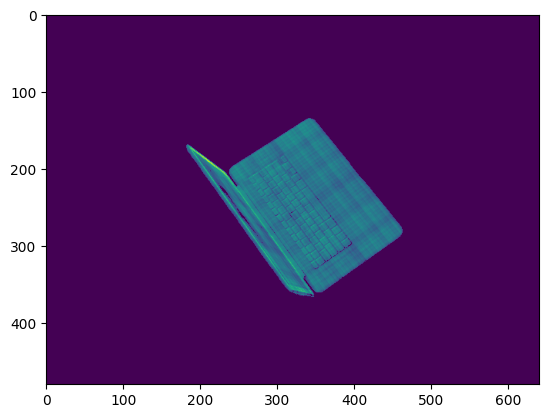

In [15]:
w, h = 640, 480
img_part_0 = render_result_test['0']['seg'].view([h, w, 1]).cpu().numpy()
img_part_0[img_part_0 < 0.5] = 0
plt.imshow(img_part_0)

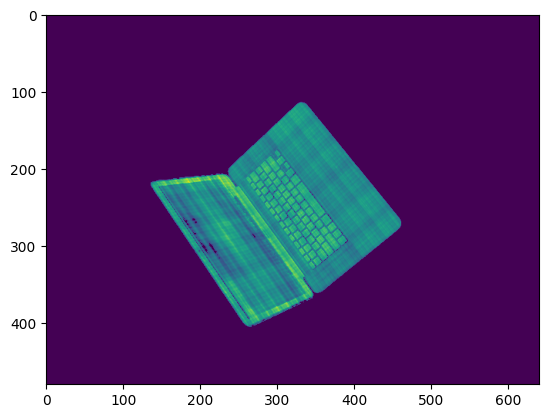

In [16]:
img_part_1 = render_result_test['1']['seg'].view([h, w, 1]).cpu().numpy()
img_part_1[img_part_1 < 0.5] = 0
plt.imshow(img_part_1)

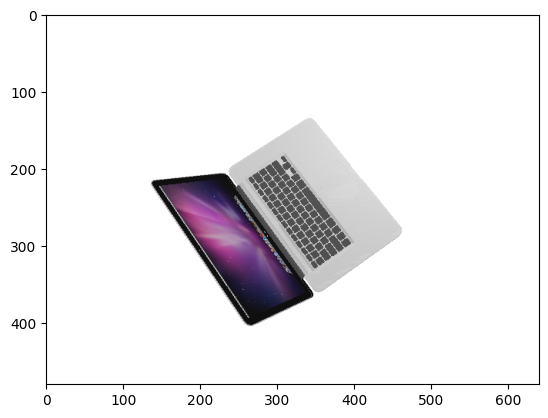

In [17]:
gt = data_dict['rgb'].view([h, w, 3]).cpu().numpy()
plt.imshow(gt)
